# SAPP analysis

 **Disclaimer**: notebook in progress, only to illustrate new graphs with regional model !

In [1]:

from utils import *

In [2]:
RESULTS_FOLDER = 'simulations_run_20250120_165705' # Name of the folder containing the results
DISPLAY = True # Usually set to False to avoid displaying the graphs

# Rename scenarios for better visualization
SCENARIOS_RENAME = {
    'simulation_baseline': 'Baseline',
}

EPM_TO_GEOJSON = {
    'South Africa': 'South_Africa',
    'Namibia': 'Namibia',
    'Mozambique': 'Mozambique',
    'United Republic of Tanzania': 'Tanzania',
    'Angola': 'Angola',
    'Botswana': 'Botswana',
    'Zambia': 'Zambia',
    'Malawi': 'Malawi',
    'Lesotho': 'Lesotho',
    'Zimbabwe': 'Zimbabwe',
    'Democratic Republic of the Congo': 'DRC',
}


DISCOUNT_RATE = 0.06
SELECT_XAXIS = [2035, 2050] # x-axis displayed range for the graphs

selected_scenario = 'Baseline'
scenario_order = ['Baseline']

# Read input and output data

In [3]:
# Create the folder path
RESULTS_FOLDER = os.path.join('..', 'output', RESULTS_FOLDER)
GRAPHS_RESULTS = 'img'
GRAPHS_RESULTS = os.path.join(RESULTS_FOLDER, GRAPHS_RESULTS)
if not os.path.exists(GRAPHS_RESULTS):
    os.makedirs(GRAPHS_RESULTS)
    print(f'Created folder {GRAPHS_RESULTS}')

In [4]:
# Read the plot specifications
dict_specs = read_plot_specs()

# Extract and process EPM inputs
epm_input = extract_epm_folder(RESULTS_FOLDER, file='WB_EPM_SAPP.gdx')
epm_input = process_epm_inputs(epm_input, dict_specs, scenarios_rename=SCENARIOS_RENAME)
mapping_gen_fuel = epm_input['pGenDataExcel'].loc[:, ['scenario', 'generator', 'fuel1']]

# Extract and process EPM results
epm_results = extract_epm_folder(RESULTS_FOLDER, file='epmresults.gdx')
epm_results = process_epm_results(epm_results, dict_specs, scenarios_rename=SCENARIOS_RENAME,
                                  mapping_gen_fuel=mapping_gen_fuel)

# Add plant colors to the dictionary
if True:
    temp = epm_results['pEnergyByPlant'].copy()
    plant_fuel_pairs = temp[['generator', 'fuel1']].drop_duplicates()
    plant_fuel_pairs['colors'] = plant_fuel_pairs['fuel1'].map(dict_specs['colors'])
    plant_to_color = dict(zip(plant_fuel_pairs['generator'], plant_fuel_pairs['colors']))
    dict_specs['colors'].update(plant_to_color)

pFuelDispatch not found in epm_dict
pPlantFuelDispatch not found in epm_dict


/Users/celia/Documents/WorldBank/Energy_planning/EPM/epm/postprocessing/utils.py:201: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  mapping_tech.replace(dict_specs['tech_mapping'], inplace=True)


# Figures

## LCOE

Displaying the LCOE of different plants for a subset of countries in the region

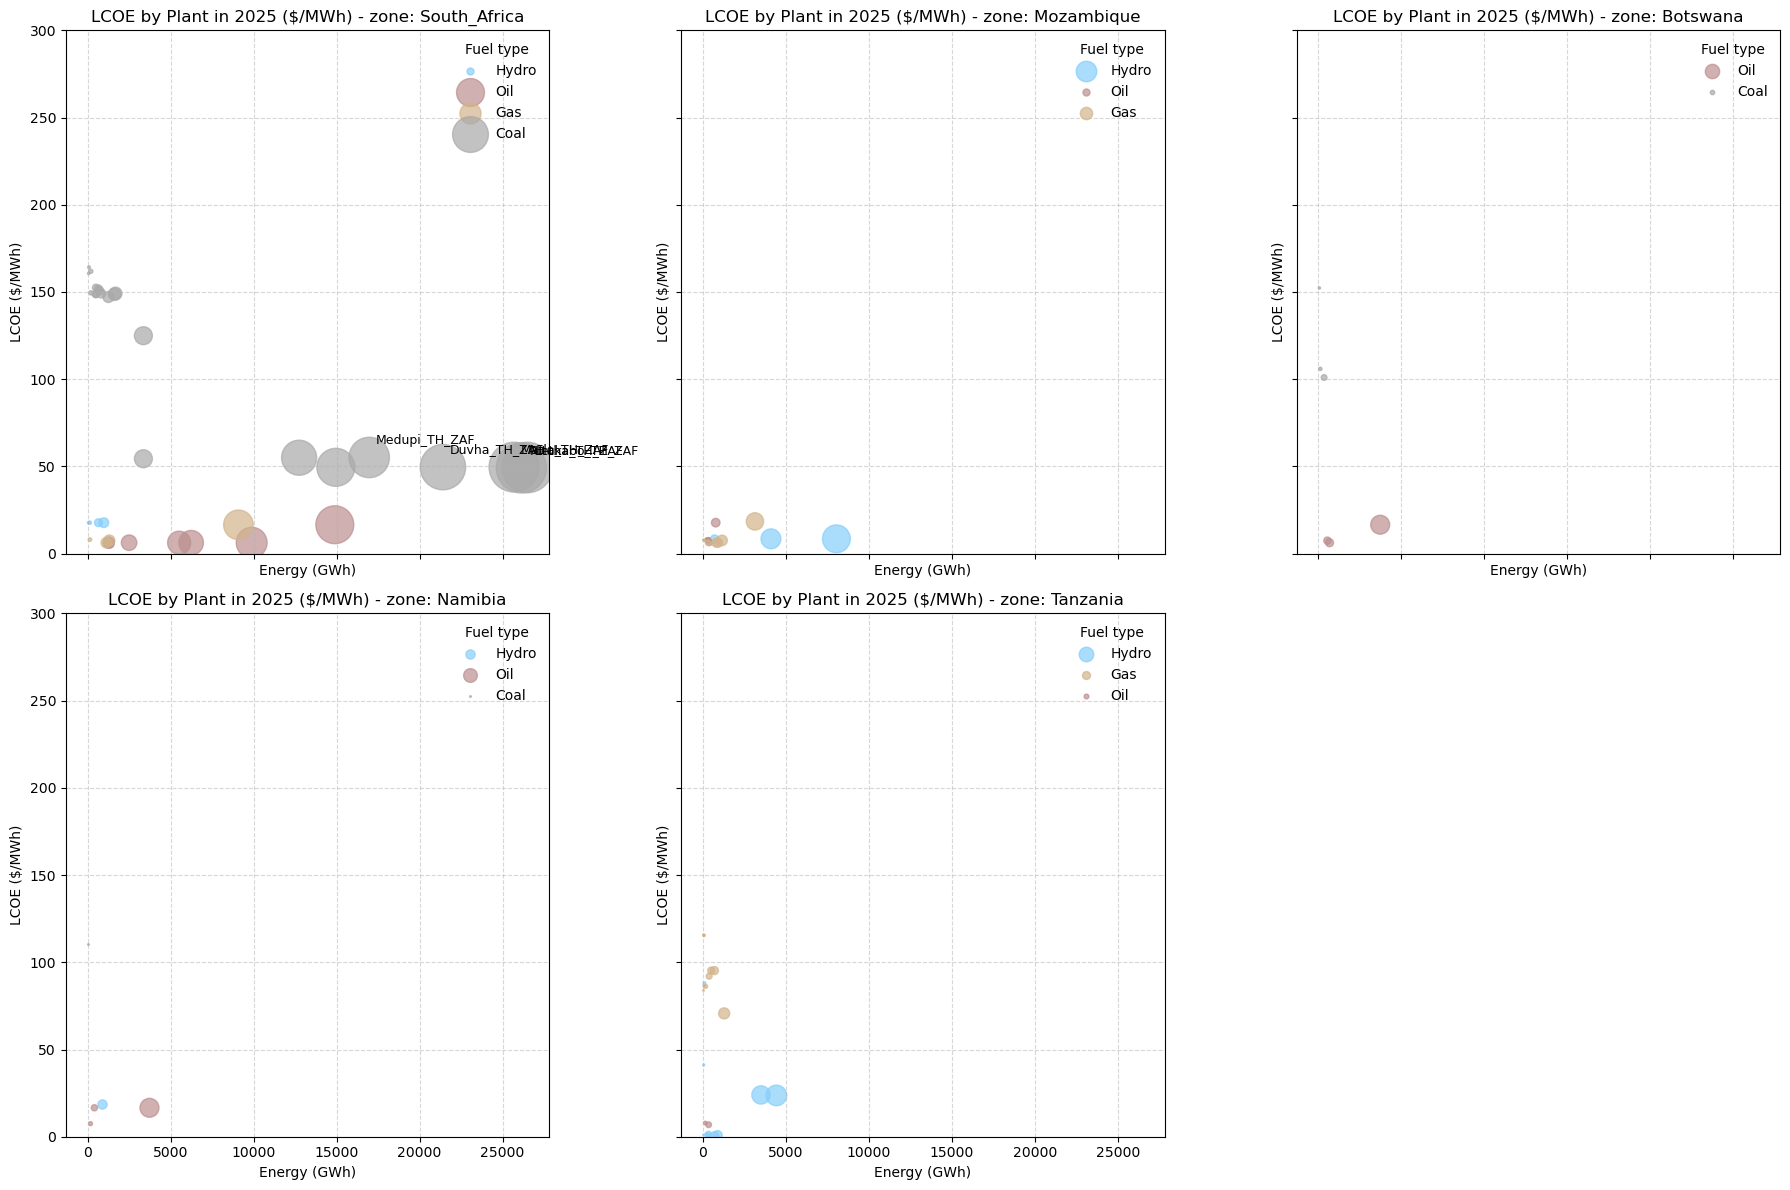

In [8]:

scenario, year = 'Baseline', 2025

x_column = 'Energy (GWh)'
y_column = 'LCOE ($/MWh)'

df = epm_results['pPlantAnnualLCOE'].copy()
df = df.rename(columns={'value': y_column})
df1 = epm_results['pEnergyByPlant'].copy()
df1 = df1.rename(columns={'value': x_column})
df = df.merge(df1, on=['scenario', 'zone', 'generator', 'year', 'fuel1'])

color_col = 'fuel1'
years = SELECT_XAXIS

temp = df[df['year'] == year]
temp = temp[temp['scenario'] == scenario]
# only if energy is positive
temp = temp[temp[x_column] > 1]
temp = temp[temp[color_col].isin(['Hydro', 'Oil', 'Coal', 'Gas'])]
# temp = temp.loc[temp.zone == 'South_Africa']

temp = temp.loc[temp.zone.isin(['South_Africa', 'Mozambique', 'Namibia', 'Tanzania', 'Botswana'])]
filename = None # Only for display in the notebook
subplot_scatter(temp, x_column, y_column, color_col, dict_specs['colors'],
                            ymax=300, title='LCOE by Plant in {} ($/MWh)'.format(year), legend='Fuel type',
                            filename=filename, xmax=None, size_scale=0.05, annotate_thresh=15000, 
                             subplot_column='zone', figsize=(6,6)
                             )

## Costs

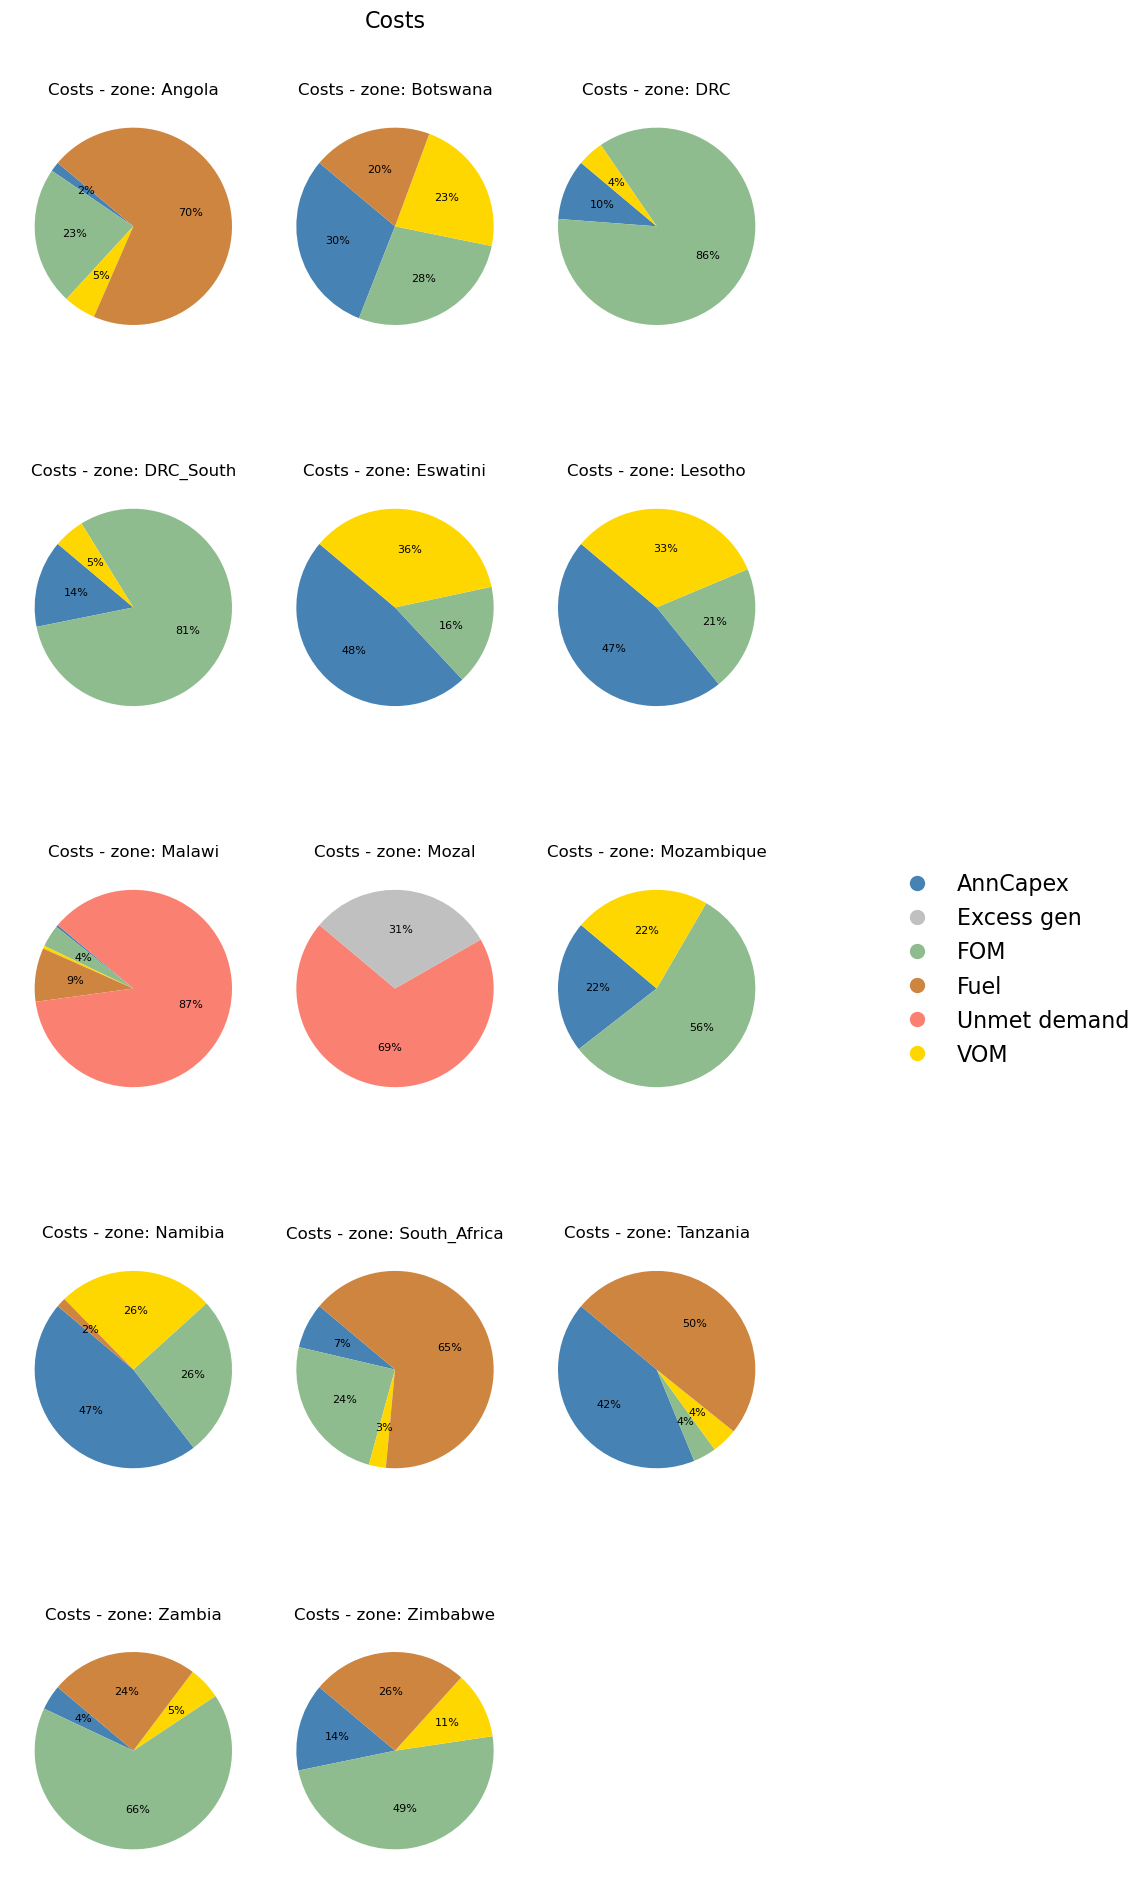

In [9]:
scenario, year = 'Baseline', 2025

selected_costs =  ['Annualized capex: $m',
 'Fixed O&M: $m',
 'Variable O&M: $m',
 'Total fuel Costs: $m',
 'Transmission additions: $m',
 'Unmet demand costs: $m',
 'Excess generation: $m']

selected_names = ['AnnCapex', 'FOM', 'VOM', 'Fuel', 'Transmissions', 'Unmet demand', 'Excess gen', 'VRE curtail', 'Import', 'Export', 'Spinning reserve']
name_mapping = dict(zip(selected_costs, selected_names))


df = epm_results['pCostSummary'].copy()
df = df.loc[(df['year'] == year) & (df['scenario'] == scenario)]
df = df[df.attribute.isin(selected_costs)]


subplot_pie_new(df, index='attribute', dict_colors=dict_specs['colors'], subplot_column='zone', title='Costs', figsize=(8,4), 
                percent_cap=1, filename=None, rename=name_mapping, 
                bbox_to_anchor=(1.1, 0.5), loc='center left'
                )


## Maps

In [10]:
zone_map, centers = create_zonemap(dict_specs['map_countries'], selected_countries=list(EPM_TO_GEOJSON.keys()), map_epm_to_geojson=EPM_TO_GEOJSON)

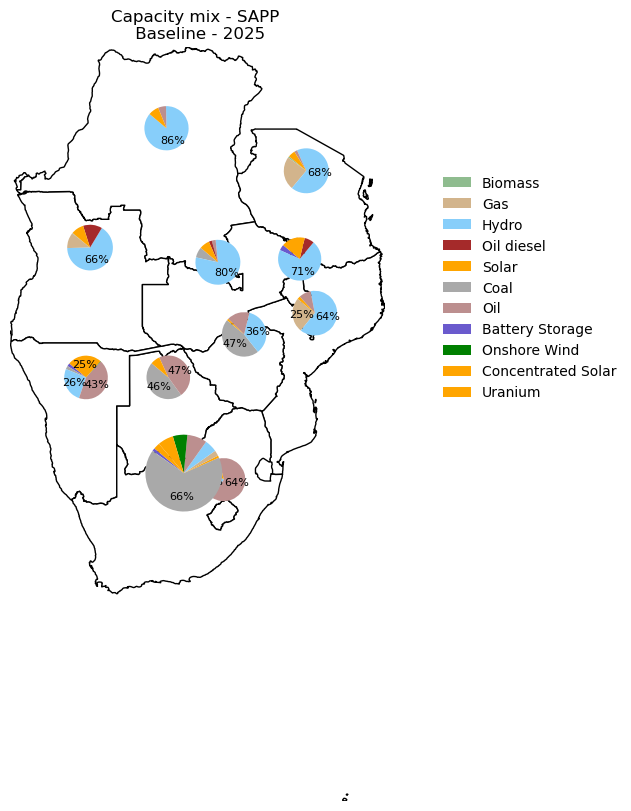

In [11]:
pCapacityByFuel = epm_results['pCapacityByFuel'].copy()
pCapacityByFuel = pCapacityByFuel.loc[pCapacityByFuel.zone.isin(list(EPM_TO_GEOJSON.values()))]
make_capacity_mix_map(zone_map, pCapacityByFuel, dict_specs['colors'], centers, year=2025, region='SAPP', scenario='Baseline', filename=None,
                      map_epm_to_geojson=EPM_TO_GEOJSON, figsize=(12,8), bbox_to_anchor=(0.7, 0.5), loc='center left', 
                      pie_sizing=True,  min_size=1.5, max_size=4)

## Capacity evolution

Displaying evolution of capacity across time for a subset of the countries

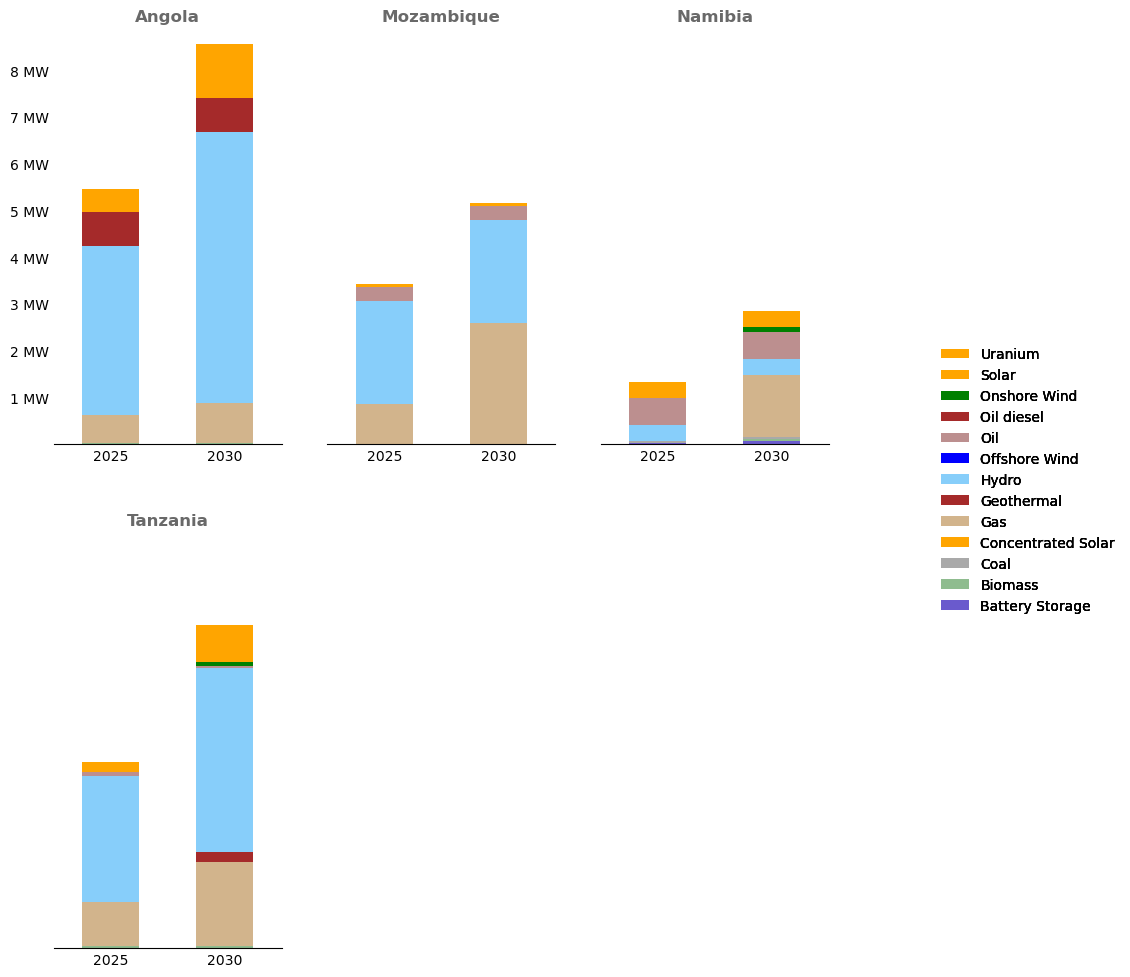

In [14]:
df = epm_results['pCapacityByFuel'].copy()
df['value'] = df['value'] / 1e3
filename = f'{GRAPHS_RESULTS}/CapacityMixClusteredStackedAreaPlot.png'
filename = None # Only for display in the notebook


make_stacked_bar_subplots(df, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis='zone',
                          column_value='value', column_multiple_bars='year', select_xaxis=['Namibia', 'Tanzania', 'Angola', 'Mozambique'],
                          format_y=lambda y, _: '{:.0f} MW'.format(y), cap=800)

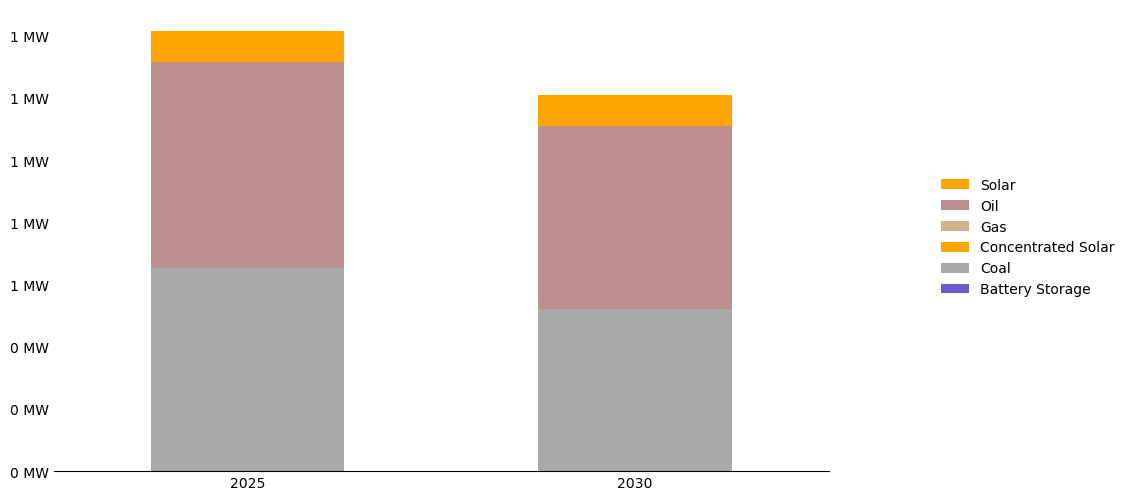

In [15]:
# zooming in on a specific country

make_stacked_bar_subplots(df, filename, dict_specs['colors'], column_stacked='fuel', column_xaxis=None,
                          column_value='value', column_multiple_bars='year', select_xaxis=None,
                          format_y=lambda y, _: '{:.0f} MW'.format(y), cap=20, selected_zone='Botswana')